In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import multiprocessing as mp
import numpy as np
from numpy.random import multivariate_normal
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from operator import xor

In [3]:
from classifier import *
from ntk import *
from Q_minimization import *
from train import *

### Define Dimensions

In [130]:
d = 1000
N = 100

### Define Dataset (Woodworth et al.)

In [302]:
np.random.seed(1993)

learning_rate = 0.001
num_epochs = int(1e7)
tol = 1e-4

# data
s = 5
noise_var = 0.01

X_train = multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=N)
X_test = multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=2000)
w_star = np.zeros(d)
support = np.random.choice(np.arange(d), s, replace=False)
w_star[support] = 1/np.sqrt(s)
y_train = np.dot(X_train, w_star) + np.sqrt(noise_var) * np.random.randn(N)
y_test = np.dot(X_test, w_star)

# reshape 
X_train = X_train.transpose()
X_test = X_test.transpose()
y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)

In [303]:
y_train.shape, X_train.shape

((1, 100), (1000, 100))

In [304]:
y_train[:10]

array([[ 0.97442131, -0.03443851,  0.11475944, -0.59585897, -0.58550922,
         0.52219816,  0.86189767,  1.17750498, -0.29624903, -1.16301883,
         1.04918621,  0.63755006, -0.21089975,  0.81986804,  0.12755566,
        -0.47487567,  1.07080965,  0.79171538, -0.88066661,  0.37329762,
         3.38183174,  1.24175949, -0.81216761, -0.24203292, -0.07114005,
         1.32371522,  0.16357318, -0.87121805, -1.2527088 , -0.75484837,
         0.5083363 , -1.68221124,  2.2794866 ,  0.08899416, -0.14566207,
         0.92715471,  1.21095997, -0.18609248,  1.07015944, -0.34101408,
         2.44594421,  0.69776946,  1.88886633,  1.20955053,  1.46324472,
        -1.16337416, -0.13139414, -1.13760487,  0.44678667, -1.35158972,
        -0.90937088, -0.67424433, -1.51200678,  0.15511929,  0.93615925,
        -1.41573205, -0.0073047 , -0.01618425, -0.22513265,  1.32681088,
        -2.51511537, -0.69150301, -0.65166486, -1.49949885,  2.05780945,
         0.26063029, -0.08180786, -0.53470401,  0.4

### Empirical Gradient Flow

In [228]:
u_p_0, v_p_0, u_n_0, v_n_0 = symmetric_init(alpha=0.0001, s=0, d=d)
u_p_0[:5], v_p_0[:5], u_n_0[:5], v_n_0[:5]

(array([[0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01]]), array([[0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01]]), array([[0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01]]), array([[0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01]]))

In [229]:
results = train(
    u_p_0=u_p_0,
    v_p_0=v_p_0,
    u_n_0=u_n_0,
    v_n_0=v_n_0,
    x=X_train,
    y=y_train,
    step_size=1e-3,
    n_epochs=int(1e7),
    eval_freq=1000,
    early_stop=1e-4)

  2%|▏         | 154999/10000000 [00:07<07:33, 21688.58it/s]


early stop at epoch 155000...


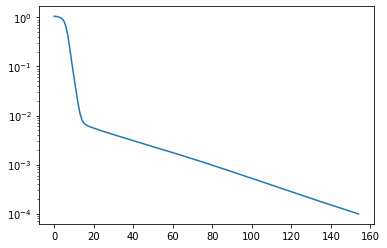

In [230]:
plot(results['training_loss'])
yscale('log')

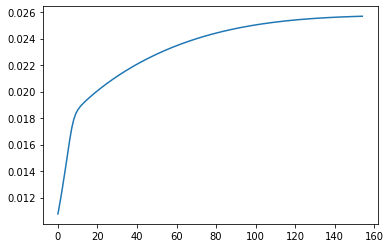

In [231]:
plot([u_p[0] for u_p in results['u_p']])

In [232]:
results['training_loss'][-1]

9.910043609911692e-05

### Estimate Q Minimization

In [233]:
w_GD = np.multiply(results['u_p'][-1], results['v_p'][-1]) - np.multiply(results['u_n'][-1], results['v_n'][-1])

In [112]:
w_opt_Q = solver(X_train, y_train, u_p_0, v_p_0, u_n_0, v_n_0, obj='Q', optim_tol=1e-4)

In [268]:
w_opt_L1 = solver(X_train, y_train, u_p_0, v_p_0, u_n_0, v_n_0, obj='L1', optim_tol=1e-2, x_0=w_GD)

In [ ]:
w_0 = np.multiply(u_p_0, v_p_0) - np.multiply(u_n_0, v_n_0)
w_GD = np.multiply(results['u_p'][-1], results['v_p'][-1]) - np.multiply(results['u_n'][-1], results['v_n'][-1])
w_0[:5], w_GD[:5]

In [116]:
print(
    w_opt_L1[:5],
    w_opt_Q[:5],
    w_GD[:5]
)

[ 6.57596011e-01 -4.04695116e-05  7.26846121e-04 -3.50335469e-04
 -4.22639641e-01] [ 0.58874086  0.14348493  0.04859853  0.11472693 -0.27461429] [[ 0.58377247]
 [ 0.14959267]
 [ 0.04889034]
 [ 0.11514435]
 [-0.27347578]]


In [117]:
print(
    np.linalg.norm(w_opt_L1.reshape(-1,) - w_GD.reshape(-1,), ord=2),
    np.linalg.norm(w_opt_Q.reshape(-1,) - w_GD.reshape(-1,), ord=2)
)

0.2992659134431575 0.011027338852723553


In [104]:
x0 = w_GD.reshape(-1,)
f = lambda v: np.linalg.norm(v, ord=1)
f(x0)

1.782436700228738

In [105]:
print(
    q_func(w_0.reshape(-1, 1), u_p_0, v_p_0, u_n_0, v_n_0),
    q_func(w_GD.reshape(-1, 1), u_p_0, v_p_0, u_n_0, v_n_0),
    q_func(w_opt_Q.reshape(-1, 1), u_p_0, v_p_0, u_n_0, v_n_0),
    q_func(w_opt_L1.reshape(-1, 1), u_p_0, v_p_0, u_n_0, v_n_0)
)

[0.] [0.56963215] [0.58831237] [0.6591017]


In [202]:
y_pred_GD = np.matmul(w_GD.transpose(), X_train)
y_pred_GD    

array([[ 0.96757834, -0.03083273,  0.11349448, -0.59338398, -0.58554856,
         0.52154415,  0.86449588,  1.17623348, -0.2968802 , -1.16320501,
         1.0478957 ,  0.63493182, -0.21056437,  0.82047699,  0.13110498,
        -0.47493383,  1.06991441,  0.79075115, -0.8741207 ,  0.37268224,
         3.37985349,  1.24144796, -0.81298007, -0.23757999, -0.06665145,
         1.32221803,  0.1654678 , -0.86815804, -1.25028323, -0.75321295,
         0.5019183 , -1.68270914,  2.28073405,  0.08996969, -0.14102229,
         0.92553403,  1.20778401, -0.18112321,  1.06878898, -0.33841365,
         2.43891267,  0.69457819,  1.88624063,  1.20820684,  1.46211608,
        -1.16192417, -0.13007331, -1.13626675,  0.44629222, -1.34841887,
        -0.90860346, -0.67222679, -1.51096467,  0.14977687,  0.93170086,
        -1.4144078 , -0.0108007 , -0.01650372, -0.22811212,  1.32611594,
        -2.51111003, -0.69218253, -0.65419079, -1.495913  ,  2.05663814,
         0.26066886, -0.07932244, -0.53520669,  0.4

In [107]:
y_pred_Q = np.matmul(w_opt_Q.transpose(), X_train)
y_pred_Q

array([0.72789603, 0.1455399 , 1.9854366 ])

In [108]:
y_pred_L1 = np.matmul(w_opt_L1.transpose(), X_train)
y_pred_L1

array([0.72789603, 0.1455399 , 1.9854366 ])

In [201]:
y_train

array([[ 0.97442131, -0.03443851,  0.11475944, -0.59585897, -0.58550922,
         0.52219816,  0.86189767,  1.17750498, -0.29624903, -1.16301883,
         1.04918621,  0.63755006, -0.21089975,  0.81986804,  0.12755566,
        -0.47487567,  1.07080965,  0.79171538, -0.88066661,  0.37329762,
         3.38183174,  1.24175949, -0.81216761, -0.24203292, -0.07114005,
         1.32371522,  0.16357318, -0.87121805, -1.2527088 , -0.75484837,
         0.5083363 , -1.68221124,  2.2794866 ,  0.08899416, -0.14566207,
         0.92715471,  1.21095997, -0.18609248,  1.07015944, -0.34101408,
         2.44594421,  0.69776946,  1.88886633,  1.20955053,  1.46324472,
        -1.16337416, -0.13139414, -1.13760487,  0.44678667, -1.35158972,
        -0.90937088, -0.67424433, -1.51200678,  0.15511929,  0.93615925,
        -1.41573205, -0.0073047 , -0.01618425, -0.22513265,  1.32681088,
        -2.51511537, -0.69150301, -0.65166486, -1.49949885,  2.05780945,
         0.26063029, -0.08180786, -0.53470401,  0.4

### Generate Plots

In [329]:
alpha_range = np.logspace(-5, -0.6, 20)
alpha_range

array([1.00000000e-05, 1.70442913e-05, 2.90507865e-05, 4.95150067e-05,
       8.43948197e-05, 1.43844989e-04, 2.45173589e-04, 4.17881006e-04,
       7.12248558e-04, 1.21397719e-03, 2.06913808e-03, 3.52669921e-03,
       6.01100886e-03, 1.02453386e-02, 1.74624535e-02, 2.97635144e-02,
       5.07298009e-02, 8.64653503e-02, 1.47374062e-01, 2.51188643e-01])

In [330]:
s_range = [0, 0.5, 0.7, 0.9, 0.99]
s_range

[0, 0.5, 0.7, 0.9, 0.99]

In [331]:
results = {}
for s in s_range:
    for alpha in alpha_range:
        u_p_0, v_p_0, u_n_0, v_n_0 = symmetric_init(alpha=alpha, s=s, d=d)
        results[(s, alpha)] = train(
            u_p_0=u_p_0,
            v_p_0=v_p_0,
            u_n_0=u_n_0,
            v_n_0=v_n_0,
            x=X_train,
            y=y_train,
            step_size=1e-3,
            n_epochs=int(1e7),
            eval_freq=1000,
            early_stop=1e-4)

  0%|          | 1645/10000000 [00:00<10:07, 16448.02it/s]

early stop at epoch 297000...


  0%|          | 3450/10000000 [00:00<09:47, 17017.24it/s]

early stop at epoch 263000...


  0%|          | 3240/10000000 [00:00<10:21, 16089.39it/s]

early stop at epoch 230000...


  0%|          | 1347/10000000 [00:00<12:22, 13461.80it/s]

early stop at epoch 198000...


  0%|          | 1537/10000000 [00:00<10:50, 15368.15it/s]

early stop at epoch 165000...


  0%|          | 1607/10000000 [00:00<10:22, 16068.90it/s]

early stop at epoch 134000...


  0%|          | 1750/10000000 [00:00<09:31, 17491.63it/s]

early stop at epoch 103000...


  0%|          | 1475/10000000 [00:00<11:18, 14744.67it/s]

early stop at epoch 77000...


  0%|          | 1512/10000000 [00:00<11:01, 15115.29it/s]

early stop at epoch 57000...


  0%|          | 1424/10000000 [00:00<11:42, 14232.01it/s]

early stop at epoch 43000...


  0%|          | 2860/10000000 [00:00<11:37, 14329.24it/s]

early stop at epoch 33000...


  0%|          | 3081/10000000 [00:00<10:38, 15656.01it/s]

early stop at epoch 25000...


  0%|          | 1561/10000000 [00:00<10:41, 15591.91it/s]

early stop at epoch 18000...


  0%|          | 1589/10000000 [00:00<10:29, 15889.37it/s]

early stop at epoch 13000...


  0%|          | 1656/10000000 [00:00<10:03, 16557.37it/s]

early stop at epoch 8000...


  0%|          | 0/10000000 [00:00<?, ?it/s]

early stop at epoch 5000...
early stop at epoch 3000...


  0%|          | 0/10000000 [00:00<?, ?it/s]

early stop at epoch 2000...
early stop at epoch 2000...
early stop at epoch 1000...


  0%|          | 1576/10000000 [00:00<10:34, 15758.89it/s]

early stop at epoch 265000...


  0%|          | 1502/10000000 [00:00<11:06, 15009.53it/s]

early stop at epoch 232000...


  0%|          | 1568/10000000 [00:00<10:37, 15678.26it/s]

early stop at epoch 199000...


  0%|          | 1560/10000000 [00:00<10:40, 15598.60it/s]

early stop at epoch 167000...


  0%|          | 1570/10000000 [00:00<10:36, 15699.87it/s]

early stop at epoch 135000...


  0%|          | 1788/10000000 [00:00<09:19, 17871.92it/s]

early stop at epoch 105000...


  0%|          | 1782/10000000 [00:00<09:21, 17818.23it/s]

early stop at epoch 78000...


  0%|          | 3439/10000000 [00:00<09:39, 17263.01it/s]

early stop at epoch 58000...


  0%|          | 1547/10000000 [00:00<10:46, 15468.32it/s]

early stop at epoch 43000...


  0%|          | 3590/10000000 [00:00<09:17, 17924.58it/s]

early stop at epoch 33000...


  0%|          | 3402/10000000 [00:00<09:44, 17092.84it/s]

early stop at epoch 25000...


  0%|          | 1658/10000000 [00:00<10:03, 16577.84it/s]

early stop at epoch 18000...


  0%|          | 3430/10000000 [00:00<09:58, 16703.85it/s]

early stop at epoch 13000...


  0%|          | 1749/10000000 [00:00<09:31, 17484.10it/s]

early stop at epoch 9000...


  0%|          | 0/10000000 [00:00<?, ?it/s]

early stop at epoch 5000...
early stop at epoch 3000...


  0%|          | 0/10000000 [00:00<?, ?it/s]

early stop at epoch 2000...
early stop at epoch 2000...
early stop at epoch 1000...


  0%|          | 1716/10000000 [00:00<09:42, 17156.25it/s]

early stop at epoch 1000...


  0%|          | 1664/10000000 [00:00<10:01, 16633.19it/s]

early stop at epoch 230000...


  0%|          | 1709/10000000 [00:00<09:45, 17085.90it/s]

early stop at epoch 197000...


  0%|          | 1488/10000000 [00:00<11:12, 14872.57it/s]

early stop at epoch 165000...


  0%|          | 3562/10000000 [00:00<09:25, 17675.72it/s]

early stop at epoch 133000...


  0%|          | 1592/10000000 [00:00<10:28, 15913.00it/s]

early stop at epoch 103000...


  0%|          | 1707/10000000 [00:00<09:45, 17065.70it/s]

early stop at epoch 77000...


  0%|          | 3620/10000000 [00:00<09:15, 18005.39it/s]

early stop at epoch 57000...


  0%|          | 3519/10000000 [00:00<09:35, 17381.18it/s]

early stop at epoch 43000...


  0%|          | 1715/10000000 [00:00<09:43, 17145.40it/s]

early stop at epoch 32000...


  0%|          | 1728/10000000 [00:00<09:38, 17278.99it/s]

early stop at epoch 24000...


  0%|          | 1779/10000000 [00:00<09:22, 17783.83it/s]

early stop at epoch 18000...


  0%|          | 1705/10000000 [00:00<09:46, 17046.97it/s]

early stop at epoch 13000...


  0%|          | 1730/10000000 [00:00<09:38, 17294.78it/s]

early stop at epoch 8000...


  0%|          | 0/10000000 [00:00<?, ?it/s]

early stop at epoch 5000...
early stop at epoch 3000...


  0%|          | 0/10000000 [00:00<?, ?it/s]

early stop at epoch 2000...
early stop at epoch 2000...
early stop at epoch 1000...


  0%|          | 1737/10000000 [00:00<09:35, 17361.66it/s]

early stop at epoch 1000...
early stop at epoch 1000...


  0%|          | 3513/10000000 [00:00<09:29, 17563.37it/s]

early stop at epoch 158000...


  0%|          | 1885/10000000 [00:00<08:50, 18846.96it/s]

early stop at epoch 127000...


  0%|          | 3609/10000000 [00:00<09:17, 17927.45it/s]

early stop at epoch 97000...


  0%|          | 3663/10000000 [00:00<09:08, 18226.90it/s]

early stop at epoch 72000...


  0%|          | 1865/10000000 [00:00<08:56, 18646.99it/s]

early stop at epoch 54000...


  0%|          | 1761/10000000 [00:00<09:28, 17600.99it/s]

early stop at epoch 40000...


  0%|          | 1477/10000000 [00:00<11:17, 14766.32it/s]

early stop at epoch 31000...


  0%|          | 1380/10000000 [00:00<12:04, 13795.61it/s]

early stop at epoch 23000...


  0%|          | 1589/10000000 [00:00<10:29, 15880.02it/s]

early stop at epoch 17000...


  0%|          | 1404/10000000 [00:00<11:52, 14037.03it/s]

early stop at epoch 12000...


  0%|          | 1570/10000000 [00:00<10:37, 15689.80it/s]

early stop at epoch 8000...


  0%|          | 1524/10000000 [00:00<10:56, 15238.92it/s]

early stop at epoch 5000...


  0%|          | 999/10000000 [00:00<10:50, 15359.58it/s]

early stop at epoch 3000...
early stop at epoch 2000...
early stop at epoch 1000...



  0%|          | 0/10000000 [00:00<?, ?it/s]

early stop at epoch 1000...
early stop at epoch 1000...
early stop at epoch 1000...
early stop at epoch 1000...


  0%|          | 1585/10000000 [00:00<10:30, 15845.90it/s]

early stop at epoch 1000...


  0%|          | 3473/10000000 [00:00<09:38, 17280.87it/s]

early stop at epoch 48000...


  0%|          | 1784/10000000 [00:00<09:20, 17832.32it/s]

early stop at epoch 36000...


  0%|          | 1763/10000000 [00:00<09:27, 17623.71it/s]

early stop at epoch 27000...


  0%|          | 1814/10000000 [00:00<09:11, 18135.82it/s]

early stop at epoch 20000...


  0%|          | 1799/10000000 [00:00<09:15, 17988.69it/s]

early stop at epoch 15000...


  0%|          | 1730/10000000 [00:00<09:38, 17289.63it/s]

early stop at epoch 10000...


  0%|          | 1620/10000000 [00:00<10:17, 16193.88it/s]

early stop at epoch 6000...


  0%|          | 0/10000000 [00:00<?, ?it/s]

early stop at epoch 4000...
early stop at epoch 3000...


  0%|          | 0/10000000 [00:00<?, ?it/s]

early stop at epoch 2000...
early stop at epoch 1000...
early stop at epoch 1000...
early stop at epoch 1000...


  0%|          | 999/10000000 [00:00<10:15, 16254.72it/s]

early stop at epoch 1000...
early stop at epoch 1000...
early stop at epoch 1000...
early stop at epoch 1000...



  0%|          | 999/10000000 [00:00<09:49, 16963.25it/s]

early stop at epoch 1000...
early stop at epoch 1000...
early stop at epoch 1000...


In [332]:
test_loss = {}
train_loss = {}
excess_L1 = {}
for k, v in results.items():
    u_p, v_p, u_n, v_n = v['u_p'][-1], v['v_p'][-1], v['u_n'][-1], v['v_n'][-1]
    w = np.multiply(u_p, v_p) - np.multiply(u_n, v_n)
    test_loss[k] = current_training_loss(u_p, v_p, u_n, v_n, X_test, y_test)
    train_loss[k] = current_training_loss(u_p, v_p, u_n, v_n, X_train, y_train)
    excess_L1[k] = np.linalg.norm(w_opt_L1.reshape(-1,) - w.reshape(-1,), ord=2)

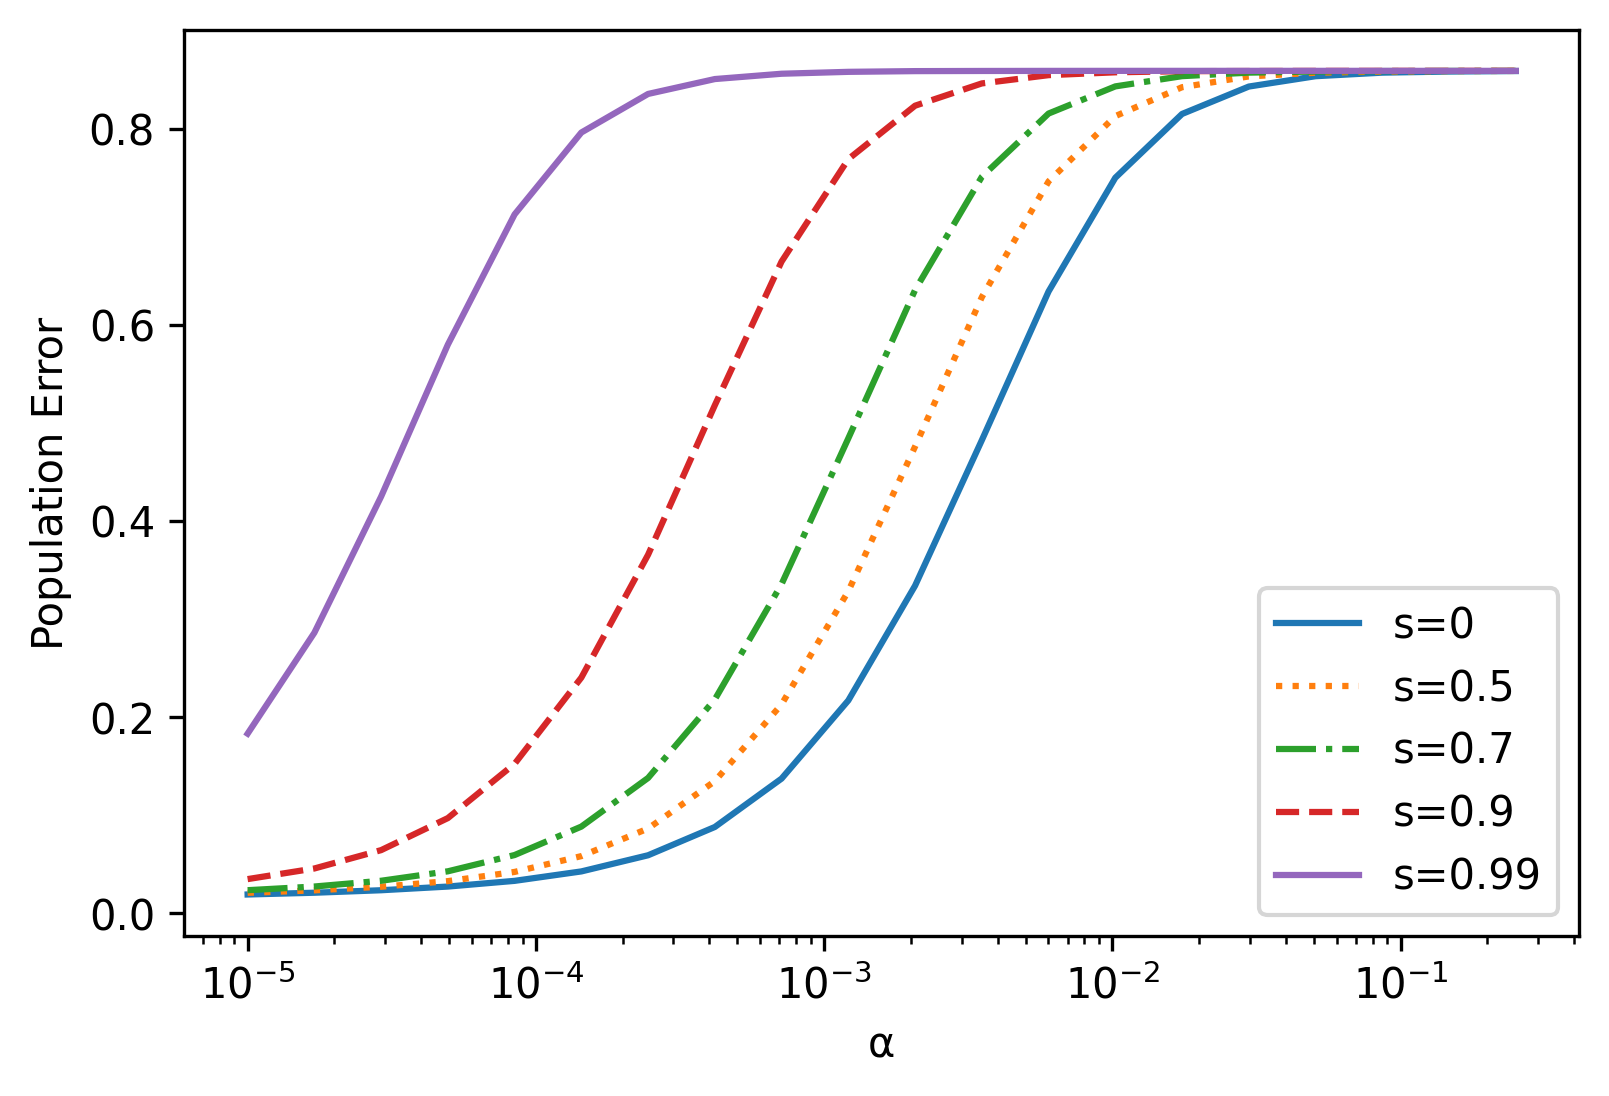

In [340]:
linstyles = ['', ':', '-.', '--', '-']
for s, style in zip(s_range, linstyles):
    plot(alpha_range, [v for k, v in test_loss.items() if k[0] == s], style)
    
legend([f's={s}' for s in s_range])
ylabel('Population Error')
xlabel('α')
xscale('log')
#plt.yticks([]);

### Effect Of LR

In [341]:
alpha_range = np.logspace(-5, -0.6, 20)
alpha_range

array([1.00000000e-05, 1.70442913e-05, 2.90507865e-05, 4.95150067e-05,
       8.43948197e-05, 1.43844989e-04, 2.45173589e-04, 4.17881006e-04,
       7.12248558e-04, 1.21397719e-03, 2.06913808e-03, 3.52669921e-03,
       6.01100886e-03, 1.02453386e-02, 1.74624535e-02, 2.97635144e-02,
       5.07298009e-02, 8.64653503e-02, 1.47374062e-01, 2.51188643e-01])

In [352]:
LR_range = [1e-3, 1e-2, 1e-1]

In [353]:
results = {}
for step_size in LR_range:
    for alpha in alpha_range:
        u_p_0, v_p_0, u_n_0, v_n_0 = symmetric_init(alpha=alpha, s=0, d=d)
        results[(step_size, alpha)] = train(
            u_p_0=u_p_0,
            v_p_0=v_p_0,
            u_n_0=u_n_0,
            v_n_0=v_n_0,
            x=X_train,
            y=y_train,
            step_size=step_size,
            n_epochs=int(1e7),
            eval_freq=1000,
            early_stop=1e-4)

  0%|          | 2545/10000000 [00:00<13:10, 12645.30it/s]

early stop at epoch 297000...


  0%|          | 2253/10000000 [00:00<15:06, 11028.98it/s]

early stop at epoch 263000...


  0%|          | 919/10000000 [00:00<18:08, 9186.50it/s]

early stop at epoch 230000...


  0%|          | 1189/10000000 [00:00<14:01, 11888.71it/s]

early stop at epoch 198000...


  0%|          | 1255/10000000 [00:00<13:17, 12542.45it/s]

early stop at epoch 165000...


  0%|          | 2297/10000000 [00:00<14:43, 11309.73it/s]

early stop at epoch 134000...


  0%|          | 1169/10000000 [00:00<14:16, 11676.56it/s]

early stop at epoch 103000...


  0%|          | 2228/10000000 [00:00<14:26, 11539.09it/s]

early stop at epoch 77000...


  0%|          | 1118/10000000 [00:00<14:54, 11176.44it/s]

early stop at epoch 57000...


  0%|          | 2401/10000000 [00:00<14:07, 11794.05it/s]

early stop at epoch 43000...


  0%|          | 952/10000000 [00:00<17:32, 9502.13it/s]

early stop at epoch 33000...


  0%|          | 1201/10000000 [00:00<13:52, 12009.15it/s]

early stop at epoch 25000...


  0%|          | 794/10000000 [00:00<20:59, 7938.00it/s]

early stop at epoch 18000...


  0%|          | 878/10000000 [00:00<19:00, 8769.83it/s]

early stop at epoch 13000...


  0%|          | 981/10000000 [00:00<17:00, 9800.03it/s]

early stop at epoch 8000...


  0%|          | 987/10000000 [00:00<16:53, 9867.82it/s]

early stop at epoch 5000...


  0%|          | 1683/10000000 [00:00<19:49, 8405.65it/s]

early stop at epoch 3000...


  0%|          | 858/10000000 [00:00<19:26, 8569.04it/s]

early stop at epoch 2000...


  0%|          | 0/10000000 [00:00<?, ?it/s]

early stop at epoch 2000...
early stop at epoch 1000...


  0%|          | 2337/10000000 [00:00<14:23, 11577.97it/s]

early stop at epoch 30000...


  0%|          | 1025/10000000 [00:00<16:16, 10244.59it/s]

early stop at epoch 27000...


  0%|          | 1011/10000000 [00:00<16:29, 10100.57it/s]

early stop at epoch 23000...


  0%|          | 2320/10000000 [00:00<14:06, 11804.73it/s]

early stop at epoch 20000...


  0%|          | 2411/10000000 [00:00<14:01, 11882.41it/s]

early stop at epoch 17000...


  0%|          | 1261/10000000 [00:00<13:13, 12606.71it/s]

early stop at epoch 14000...


  0%|          | 1241/10000000 [00:00<13:25, 12406.17it/s]

early stop at epoch 11000...


  0%|          | 1190/10000000 [00:00<14:00, 11895.22it/s]

early stop at epoch 8000...


  0%|          | 2497/10000000 [00:00<13:18, 12525.91it/s]

early stop at epoch 6000...


  0%|          | 1251/10000000 [00:00<13:19, 12508.76it/s]

early stop at epoch 5000...


  0%|          | 1249/10000000 [00:00<13:20, 12488.73it/s]

early stop at epoch 4000...


  0%|          | 0/10000000 [00:00<?, ?it/s]

early stop at epoch 3000...
early stop at epoch 2000...


  0%|          | 0/10000000 [00:00<?, ?it/s]

early stop at epoch 2000...
early stop at epoch 1000...
early stop at epoch 1000...


  0%|          | 0/10000000 [00:00<?, ?it/s]

early stop at epoch 1000...
early stop at epoch 1000...
early stop at epoch 1000...


  0%|          | 2560/10000000 [00:00<12:56, 12873.57it/s]

early stop at epoch 1000...


  0%|          | 2445/10000000 [00:00<14:17, 11665.00it/s]

early stop at epoch 3000...


  0%|          | 1270/10000000 [00:00<13:07, 12698.74it/s]

early stop at epoch 3000...


  0%|          | 0/10000000 [00:00<?, ?it/s]

early stop at epoch 3000...
early stop at epoch 2000...


  0%|          | 0/10000000 [00:00<?, ?it/s]

early stop at epoch 2000...
early stop at epoch 2000...


  0%|          | 0/10000000 [00:00<?, ?it/s]

early stop at epoch 2000...
early stop at epoch 1000...
early stop at epoch 1000...


  0%|          | 0/10000000 [00:00<?, ?it/s]

early stop at epoch 1000...
early stop at epoch 1000...
early stop at epoch 1000...


  0%|          | 0/10000000 [00:00<?, ?it/s]

early stop at epoch 1000...
early stop at epoch 1000...
early stop at epoch 1000...


  0%|          | 0/10000000 [00:00<?, ?it/s]

early stop at epoch 1000...
early stop at epoch 1000...
early stop at epoch 1000...


  0%|          | 999/10000000 [00:00<12:42, 13107.12it/s]

early stop at epoch 1000...
early stop at epoch 1000...


In [354]:
test_loss = {}
train_loss = {}
excess_L1 = {}
for k, v in results.items():
    u_p, v_p, u_n, v_n = v['u_p'][-1], v['v_p'][-1], v['u_n'][-1], v['v_n'][-1]
    w = np.multiply(u_p, v_p) - np.multiply(u_n, v_n)
    test_loss[k] = current_training_loss(u_p, v_p, u_n, v_n, X_test, y_test)
    train_loss[k] = current_training_loss(u_p, v_p, u_n, v_n, X_train, y_train)
    excess_L1[k] = np.linalg.norm(w_opt_L1.reshape(-1,) - w.reshape(-1,), ord=2)

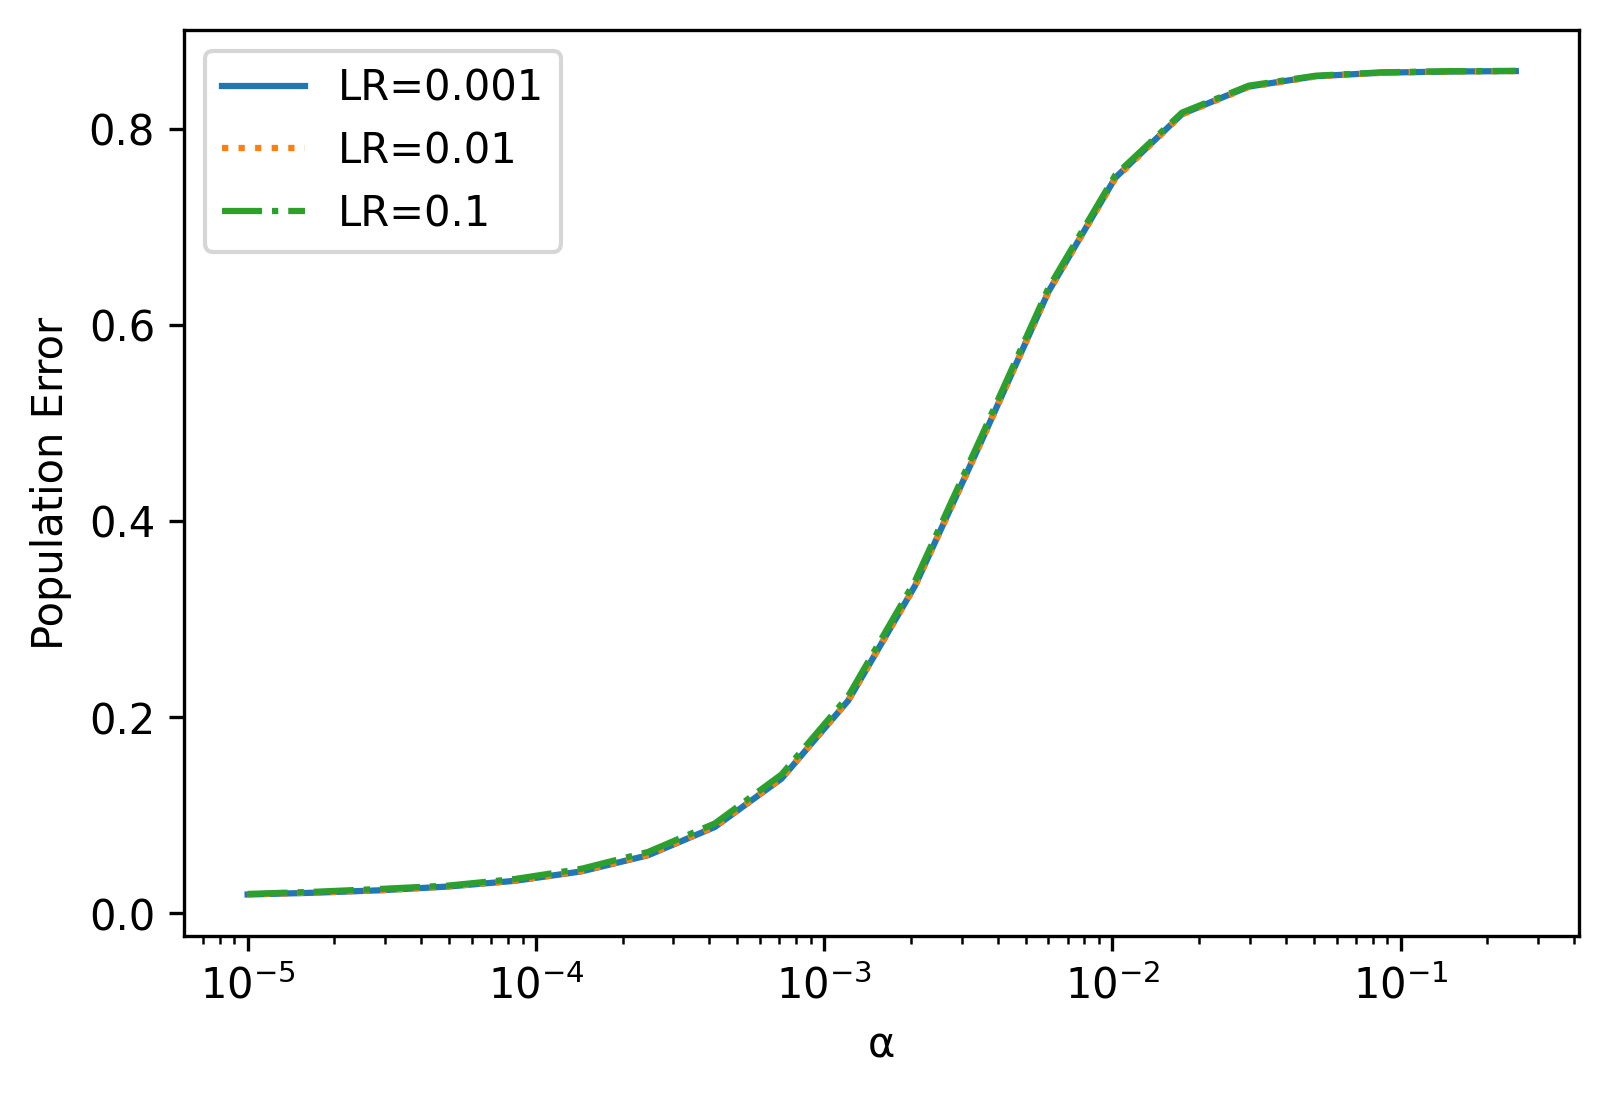

In [356]:
linstyles = ['', ':', '-.', '--']
for step_size, style in zip(LR_range, linstyles):
    plot(alpha_range, [v for k, v in test_loss.items() if k[0] == step_size], style)
    
legend([f'LR={step_size}' for step_size in LR_range])
ylabel('Population Error')
xlabel('α')
xscale('log')
#plt.yticks([]);